In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
import itertools

import warnings
warnings.filterwarnings("ignore")

In [354]:
btc_df = pd.read_csv(r'sentiment_btc.csv', index_col=0)
eth_df = pd.read_csv(r'sentiment_eth.csv', index_col=0)
price_df = pd.read_csv(r'Prices.csv', index_col=0)

In [355]:
btc_df['Date'] = pd.to_datetime(btc_df['Date'], utc=False)
btc_df = btc_df.set_index('Date')
btc_df

,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
Date,,,,,,,,
2020-07-01 08:25:58+00:00,694,165,3022,#Bitcoin S2F chart update .. RED DOT #2 🔴 http...,0.020831,0.904005,0.075164,0
2020-07-01 01:32:23+00:00,301,122,2875,Bitcoin will soon do to banks what email did t...,0.033729,0.592106,0.374165,0
2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...,0.091743,0.844816,0.063441,0
2020-07-01 17:01:32+00:00,172,148,1714,10 bitcoin to be a billionaire.,0.029795,0.782686,0.187519,0
2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...,0.001092,0.040329,0.958579,1
...,...,...,...,...,...,...,...,...
2020-08-07 16:07:32+00:00,28,10,113,"At 11:26am EST, we noticed our systems not fun...",0.782039,0.203932,0.014028,-1
2020-08-07 12:14:42+00:00,5,18,113,2017: I AM THE EYE IN THE SKY MY FRIEND\n\n201...,0.171523,0.544430,0.284047,0
2020-08-07 00:54:07+00:00,14,2,109,An ETH maxi literally told us to query this da...,0.761172,0.213993,0.024835,-1


In [356]:
eth_df['Date'] = pd.to_datetime(eth_df['Date'])
eth_df = eth_df.set_index('Date')
eth_df.head()

,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
Date,,,,,,,,
2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...,0.091743,0.844816,0.063441,0
2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...,0.001092,0.040329,0.958579,1
2020-07-01 11:33:16+00:00,207,6,1245,31 Days of Apex: Memory\nCrypto's forever fami...,0.023992,0.801558,0.174450,0
2020-07-01 20:02:49+00:00,417,75,1223,#Blockchain technology and #XRP play a fundame...,0.008470,0.540194,0.451336,0
2020-07-01 15:03:23+00:00,1395,310,1150,Calling all blockchain game enthusiasts: we ar...,0.000847,0.032527,0.966626,1


In [357]:
price_df = price_df['2020-07-01 00:00:00':'2020-08-08 00:00:00']
price_df.index = pd.to_datetime(price_df.index, utc=True)
price_df = price_df.sort_values(by='Date')

## Pre-Processing

In [358]:
price_df.index = price_df.index.date
price_df.index.name = 'Date'

In [359]:
btc_df = btc_df.drop(columns='Tweet', axis=0)
btc_df = btc_df.sort_values('Date')

In [360]:
btc_merge = btc_df

In [361]:
btc_merge.index = btc_merge.index.date
btc_merge.index.name = 'Date'

In [362]:
btc_merge['Impact'] = 2*btc_merge['Retweet']*btc_merge['classes'] + btc_merge['Likes']*btc_merge['classes']
btc_merge = pd.get_dummies(btc_merge, columns=['classes'])

In [363]:
btc_merge1 = btc_merge.groupby('Date')[['Impact', 'classes_-1', 'classes_1']].sum()
btc_merge1 = pd.merge(btc_merge1, price_df, on='Date')
btc_merge1 = btc_merge1.iloc[:, 0:4]

## Train-Test-Split

In [364]:
train = btc_merge1[:pd.to_datetime('2020-07-31').date()]
test = btc_merge1[pd.to_datetime('2020-08-01').date():]

In [365]:
x_train = train.iloc[:, 0:3]
y_train = train.iloc[:, 3]

x_test = test.iloc[:, 0:3]
y_test = test.iloc[:, 3]

## Model

In [366]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [367]:
scores = cross_val_score(model, x_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.45


In [368]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.44


In [369]:
def plot_confusion_matrix(cm, classes, 
                            normalize=False, 
                            title='Confusion matrix', 
                            cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [370]:
def Evaluation(model, X_train, y_train, X_test, y_test):
    pred = model.predict(X_train)
    yhat = model.predict(X_test)
    print(classification_report(y_test, yhat))
    print("_______________________________________________")

    train_score = accuracy_score(y_train, pred) * 100
    test_score = accuracy_score(y_test, yhat) * 100

    print(f"Train accuracy Score: {train_score}%")
    print(f"Test accuracy Score: {test_score}%")

    cnf = confusion_matrix(y_test, yhat, labels=[1,0])
    plt.figure()
    plot_confusion_matrix(cnf,classes=['output =1', 'output=0'],normalize = False, title='Confusion matrix')

    return  train_score, test_score, cnf

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      1.00      0.73         4

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7

_______________________________________________
Train accuracy Score: 100.0%
Test accuracy Score: 57.14285714285714%
Confusion matrix, without normalization
[[4 0]
 [3 0]]


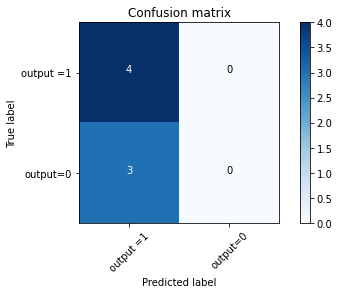

In [371]:
x, y, cnf = Evaluation(model, x_train, y_train, x_test, y_test)

results_df = pd.DataFrame(data=[["XGBoost", x, y]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])